In [521]:
import pandas as pd; pd.set_option('max_rows', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import os

In [388]:
land_area = pd.read_csv('data/historical-database-clean.csv')

path='data/'
files = [file for file in os.listdir(path) if '.xlsx' in file]
dfs = [pd.read_excel(os.path.join(path, file), sep=',') for file in files]
microregions = dfs[0]
deforestation = dfs[1]
productivity = dfs[2]

city_to_microregion = dict(dfs[0].set_index('City')['Microregion'])
citycode_to_microregion = dict(dfs[0].set_index('city_code')['Microregion'])

### 0. Total land area by microregion

In [389]:
land_area['microregion'] = land_area['city_code'].map(citycode_to_microregion)
region_prod_area = land_area.set_index('year').loc['01/01/2017'].groupby(['microregion', 'product']).sum().sort_index()
region_prod_area = region_prod_area / 100  # acres to squared kilometers unit conversion (hec to km2)
region_prod_area.columns = ['area (Km2)']
region_prod_area.head()

area (Km2)
microregion product            
Almeirim    Açaí           3.78
            Beans          1.05
            Cassava        5.80
            Cocoa          0.47
            Corn           2.40

#### Extracting microregion-product combinations with null values for destinated land area

In [486]:
out_combs_0 = region_prod_area[region_prod_area['area (Km2)']==0].index.tolist()
len(out_combs_0)

57

### 1. deforestation rate by microregion

In [391]:
dfs[1]['Microregion'] = dfs[1]['City'].map(city_to_microregion)
def_df = dfs[1].groupby(['Microregion']).sum().drop('City ID_CodIbge', 1)
def_df = (def_df.iloc[:, 1:].mean(1) / def_df.iloc[:, 0]).to_frame()
def_df.columns = ['Average deforestation area rate 2017-2019 (Km2)']
def_df.head()

,Average deforestation area rate 2017-2019 (Km2)
Microregion,
Almeirim,0.000606
Altamira,0.005061
Arari,0.000080
Belém,0.000827
Bragantina,0.000338


In [405]:
products = land_area['product'].unique()
def_rate = []
for prod in products:
    df = def_df.copy()
    df['Product'] = prod
    def_rate.append(df)
def_rate = pd.concat(def_rate).reset_index(drop=False).set_index(['Microregion', 'Product']).mean(1).to_frame().sort_index()
def_rate.columns = ['Average deforestation rate (2017-2019)']

In [406]:
def_rate

Average deforestation rate (2017-2019)
Microregion Product                                         
Almeirim    Açaí                                    0.000606
            Beans                                   0.000606
            Cassava                                 0.000606
            Cocoa                                   0.000606
            Corn                                    0.000606
...                                                      ...
Óbidos      Others                                  0.000365
            Palm oil                                0.000365
            Rice                                    0.000365
            Sorghum                                 0.000365
            Soy                                     0.000365

[242 rows x 1 columns]

### 2. Productivity by microregion and product

In [407]:
dfs[2]['Microregion'] = dfs[2]['City'].map(city_to_microregion)
total_prod = dfs[2].groupby(['Microregion', 'Product']).sum()[['Production value (R$ thousands)']].sort_index()

prod_area = pd.concat([total_prod, region_prod_area], 1)
productivity = (prod_area['Production value (R$ thousands)'] / prod_area['area (Km2)']).rename('productivity (R$/Km2)').to_frame().sort_index()
productivity

productivity (R$/Km2)
Microregion Product                        
Almeirim    Açaí                2026.190476
            Beans                132.380952
            Cassava              572.758621
            Cocoa                465.957447
            Corn                  76.666667
...                                     ...
Óbidos      Others              1613.995943
            Palm oil                    NaN
            Rice                  51.666667
            Sorghum                     NaN
            Soy                         NaN

[242 rows x 1 columns]

#### Extracting microregion-product combinations with null values for production

In [474]:
prod_col = 'Production value (R$ thousands)'
out_combs_1 = total_prod[total_prod[prod_col]==0].index.tolist()
len(out_combs_1)

55

### 4. Product environmental footprint rank

In [409]:
ranks = {
    'Livestock': 5, 'Soy': 5, 'Sorghum': 4, 'Corn': 4,
    'Beans': 3, 'Cassava': 3, 'Rice': 3, 'Others': 2,
    'Palm oil': 1, 'Açaí': 1, 'Cocoa': 1
}

In [410]:
prods_ranks = pd.DataFrame(productivity.index.map(lambda index_value: ranks[index_value[1]]), index=productivity.index, columns=['rank']).sort_index()

In [411]:
prods_ranks

rank
Microregion Product       
Almeirim    Açaí         1
            Beans        3
            Cassava      3
            Cocoa        1
            Corn         4
...                    ...
Óbidos      Others       2
            Palm oil     1
            Rice         3
            Sorghum      4
            Soy          5

[242 rows x 1 columns]

### Calculating microregion-product criteria scores

#### Get combinations where either land area or total production are null

In [487]:
out_combs = list(set(out_combs_0 + out_combs_1))
len(out_combs)

61

In [ ]:
#### Concatenating microregion-product criterias
criterias = pd.concat([region_prod_area, def_rate, -productivity, prods_ranks], 1).drop(out_combs)
# negative sign in productivity means the variable represent more environmental impact for lower values.
weights = np.array([0.4, 0.25, 0.1, 0.25])
#### Scaling criterias (0 to 10 interval)
from sklearn.preprocessing import MinMaxScaler as mms, StandardScaler as ss
scaled_criterias = mms(feature_range=(0, 10)).fit_transform(criterias)
scores = np.dot(scaled_criterias, weights)
scores = pd.DataFrame(scores, index=criterias.index, columns=['score']).sort_values('score', ascending=False).reset_index()
scaled_criterias = pd.DataFrame(scaled_criterias, index=criterias.index, columns=['score']).sort_values('score', ascending=False).reset_index()

In [609]:
scores.head(5)

,microregion,product,score
0,São Félix do Xingu,Livestock,8.852341
1,Altamira,Livestock,8.751199
2,Tucuruí,Livestock,8.136009
3,Paragominas,Livestock,6.770853
4,Conceição do Araguaia,Livestock,6.422582


In [608]:
scores.loc[[0, 1, 11, 12]].reset_index(drop=True)

,microregion,product,score
0,São Félix do Xingu,Livestock,8.852341
1,Altamira,Livestock,8.751199
2,Tucuruí,Corn,5.388740
3,Altamira,Soy,5.382863


In [625]:
scores.to_excel('microregions-products_scores.xlsx', index=False)

## Explanatory visual analysis

### Sorted Rank

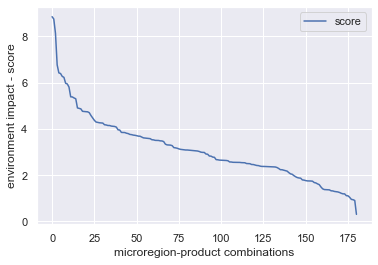

In [582]:
fig, ax = plt.subplots()
scores.plot(ax=ax)
plt.ylabel('environment impact - score')
plt.xlabel('microregion-product combinations')
plt.show()

### Sorted C02 Scores

In [601]:
scores_unstacked = scores.set_index(['microregion', 'product']).unstack().reset_index()
scores_unstacked.to_excel('scores_unstacked.xlsx')
scores_unstacked.head()

microregion     score                                          \
product                  Açaí     Beans   Cassava     Cocoa      Corn   
0          Almeirim  1.116082  2.461758  2.440069  1.194761  3.089767   
1          Altamira  2.906934  4.266671  4.258507  3.073267  4.886832   
2             Arari  0.953843       NaN  2.236826       NaN       NaN   
3             Belém  1.253259  2.555040  2.543123  1.297962  3.181959   
4        Bragantina  0.907489  2.365836  2.380529       NaN  2.986638   

                                                                  
product Livestock    Others Palm oil      Rice Sorghum       Soy  
0        3.962201  1.748938      NaN  2.463306     NaN       NaN  
1        8.751199  3.580563      NaN  4.253014     NaN  5.382863  
2        3.534212  1.491908      NaN  2.239398     NaN       NaN  
3        3.849728  1.872187      NaN  2.555486     NaN       NaN  
4        4.172134  1.683244  1.10876  2.355317     NaN  3.592803

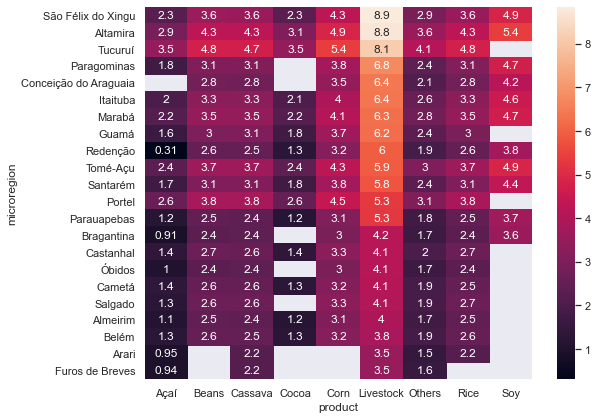

In [624]:
fig, ax = plt.subplots(figsize=(9,6), tight_layout=True)
sns.heatmap(scores_unstacked.set_index('microregion')['score'].drop(['Sorghum', 'Palm oil'], 1).sort_values('Livestock', ascending=False), annot=True)
plt.savefig('plots/microregions-products-scores.png')

In [618]:
scores_unstacked.set_index('microregion')['score'].sort_values(('Livestock'))

product,Açaí,Beans,Cassava,Cocoa,Corn,Livestock,Others,Palm oil,Rice,Sorghum,Soy
microregion,,,,,,,,,,,
Furos de Breves,0.941291,NaN,2.218063,NaN,NaN,3.527296,1.591824,NaN,NaN,NaN,NaN
Arari,0.953843,NaN,2.236826,NaN,NaN,3.534212,1.491908,NaN,2.239398,NaN,NaN
Belém,1.253259,2.555040,2.543123,1.297962,3.181959,3.849728,1.872187,NaN,2.555486,NaN,NaN
Almeirim,1.116082,2.461758,2.440069,1.194761,3.089767,3.962201,1.748938,NaN,2.463306,NaN,NaN
Salgado,1.285154,2.648640,2.644529,NaN,3.279107,4.078730,1.935125,1.371412,2.652531,NaN,NaN
Cametá,1.366599,2.573015,2.553959,1.326319,3.165674,4.123903,1.897492,1.320539,2.537970,NaN,NaN
Óbidos,1.042478,2.361674,2.393153,NaN,2.996499,4.148733,1.665442,NaN,2.368419,NaN,NaN
Castanhal,1.379775,2.666649,2.641292,1.376901,3.300668,4.149003,1.981798,1.412195,2.674269,NaN,NaN
Bragantina,0.907489,2.365836,2.380529,NaN,2.986638,4.172134,1.683244,1.108760,2.355317,NaN,3.592803
